In [1]:
# Get pandas and postgres to work together
import psycopg2 as pg
import pandas as pd
import psycopg2.extras as extras

# We are also going to do some basic viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xport.v56 #for working with XPT files (SAS outputs favored by the US government)
import pickle #for saving data extracts

In [2]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'fitness',    # DB that we are connecting to
    'port': 5432          # port we opened on AWS
}

connection = pg.connect(**connection_args)

### Download Data

Downloads Data from NHANES website (note that DXX only available from 2011 and on, prior to that had data issues and would require more data massaging)

Initial database was set up using psql and appropriate tables made for the 2017-2018 table, then used the code below to insert prior years' survey data into the table.


Database includes non-NHANES data:
    - "Fat": was created that lists fitness category by gender and body fat range. 
        - Classes: "Essential Fat", "Athlete", "Fitness", "Average" (note originally called Acceptable), "Obese"
        - Source: American Counsel on Exercise
    - "bmi_cat": lists fitness category based on BMI based on gender.
        - Classes: "Underweight", "Normal", "Overweight", "Obese"
        - Source: CDC

In [ ]:
break
# no need to run the following cells.. skip to EDA section for code

In [ ]:
years = dict([('2011-2012','G'),('2013-2014','H'),('2015-2016','I'),\
                  ('2017-2018','J')])
data_type = ['DEMO','DR1TOT','PAQ','DBQ','WHQ','BMX','DXX']

Download the data files from CDC website

In [ ]:
import requests


for key in years:
    for data in data_type:
        url = "https://wwwn.cdc.gov/Nchs/Nhanes/"+key+"/"+data+"_"+years[key]+".XPT"
        r= requests.get(url)
        filename = 'Data/Raw/'+data+'_'+years[key]+'.XPT'
        with open(filename,'wb') as out_file:
            out_file.write(r.content)

Update database tables with additional data.

Because some fields in the 2017-2018 survey tables were newer, the code below will add new columns of 0s (initially Nulls, but had some issues halfway so switch to 0s.. but this should not impact analysis.) Therefore, prior to using any field, should do a test to see distribution by survey year to make sure that it is valid across all years.


In [46]:
#helper function to be used below
def execute_values(conn, df, table,columns):
    """
    Using psycopg2.extras.execute_values() to insert the dataframe
    """
    #make new df into same columns as existing table
    missing_cols = list(set(columns) - set(df.columns))
    extra_cols = list(set(df.columns) - set(columns))
    new_df = df
    new_df =df.drop(columns = extra_cols)
    for i in missing_cols:
        blank_series = pd.Series([0]*len(df),name=i)
        new_df = pd.concat([new_df,blank_series],axis=1)
    fin_df = new_df[columns]
    
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in fin_df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(fin_df[columns]))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, pg.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_values() done")
    cursor.close()

In [51]:
#append with prior survey cycle information
data_type = ['BMX','DBQ','DEMO', 'DR1TOT', 'DXX', 'PAQ', 'WHQ']  #names of files to pull
survey = ['G','H','I'] #surveys correspond to certain years of surveys

for data in data_type:
    with open('Data/Raw/'+data+'_J.xpt', 'rb') as f:
        library = xport.v56.load(f)
    columns = list(library[data+'_J'].columns)

    for letter in survey:
        with open('Data/Raw/'+data+'_'+letter+'.xpt', 'rb') as f:
            library = xport.v56.load(f)
        execute_values(connection,library[data+'_'+letter],data,columns)

execute_values() done
execute_values() done
execute_values() done


In [53]:
#identify the missing columns

data_type = ['BMX','DBQ','DEMO', 'DR1TOT', 'DXX', 'PAQ', 'WHQ'] 
survey = ['G','H','I'] 

for data in data_type:
    with open('Data/Raw/'+data+'_J.xpt', 'rb') as f:
        library = xport.v56.load(f)
    columns = list(library[data+'_J'].columns)

    for letter in survey:
        with open('Data/Raw/'+data+'_'+letter+'.xpt', 'rb') as f:
            library = xport.v56.load(f)
        df = library[data+'_'+letter]
        missing_cols = list(set(columns) - set(df.columns))
        print(f'{data}+" "+{letter}+": "+{missing_cols}')
    

BMX+" "+G+": "+['BMIHIP', 'BMXHIP']
BMX+" "+H+": "+['BMIHIP', 'BMXHIP']
BMX+" "+I+": "+['BMIHIP', 'BMXHIP']
DBQ+" "+G+": "+['CBQ596', 'CBQ611', 'DBQ940', 'CBQ606', 'DBQ935', 'DBQ945', 'DBQ930']
DBQ+" "+H+": "+['DBQ935', 'DBQ945', 'DBQ940', 'DBQ930']
DBQ+" "+I+": "+['DBQ935', 'DBQ945', 'DBQ940', 'DBQ930']
DEMO+" "+G+": "+['DMDHSEDZ', 'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ']
DEMO+" "+H+": "+['DMDHSEDZ', 'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ']
DEMO+" "+I+": "+['DMDHSEDZ', 'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ']
DR1TOT+" "+G+": "+['DR1MRESP', 'DR1TWSZ', 'DR1SKY', 'DR1STY', 'DR1HELP']
DR1TOT+" "+H+": "+['DR1TWSZ', 'DR1HELP', 'DR1MRESP']
DR1TOT+" "+I+": "+['DR1TWSZ']
DXX+" "+G+": "+[]
DXX+" "+H+": "+[]
DXX+" "+I+": "+[]
PAQ+" "+G+": "+[]
PAQ+" "+H+": "+[]
PAQ+" "+I+": "+[]
WHQ+" "+G+": "+['WHQ200', 'WHD080U', 'WHQ190', 'WHQ225']
WHQ+" "+H+": "+['WHQ200', 'WHQ190', 'WHQ225']
WHQ+" "+I+": "+[]


Note: the missing columns are not a huge issue.
BMX - not using any body mass index measurements, in favor of body fat % to categorize fitness levels.\
DBQ - Diet Behavior data here mostly about a specific program called "My Plate", whether respondent is the primary food shopper and meal planner/prepper. Not going to use this table at all because it is a lot about milk consumption patters.\
DEMO - this includes spouse education level, age; reference person (proxy head of household) education level, age.\
DR1TOT - a few fields changed or changed their names, these are not consequential (DR1TWSZ used to be DR1TWS for drinking water, HELP and RESP refer to help with responding to survey, SKY and STY relate to using salt). During data cleanup, just left these as nulls when adding prior cycle data. These fields should not be used in analysis. given that they should not be consequential, did not bother with remapping prior cycle data to new field names.
WHQ - cycle G and H did not capture weight loss surgery, while this may be interesting, there are not many cases with these strategies being taken. Not consequential for this analysis on diet vs exercise.

## Comparing Potential Target Variables

Exploring the categories - comparing using BMI vs Body Fat to determine someone's fitness level

In [4]:
query = '''
SELECT DISTINCT dxx.seqn, 
	CASE demo.riagendr WHEN '1.0' THEN 'M' WHEN '2.0' THEN 'F' ELSE demo.riagendr END, 
	demo.ridageyr, dxx.dxdtopf,  bmx.bmxbmi, fat.category, bmi_cat.bmi_category
FROM dxx
LEFT JOIN demo
	ON dxx.seqn = demo.seqn
LEFT JOIN bmx
    ON dxx.seqn = bmx.seqn
JOIN fat
	ON demo.riagendr = fat.gender AND dxdtopf >= fat.low AND dxdtopf < fat.high
JOIN bmi_cat
    ON bmx.bmxbmi >= bmi_cat.low AND bmx.bmxbmi < bmi_cat.high
WHERE demo.ridageyr >= 18
ORDER BY dxx.seqn
'''

cat_comp = pd.read_sql(query,connection)

In [5]:
table = cat_comp.pivot_table(index='bmi_category',columns='category',aggfunc='count')['seqn'].copy()

column_order = ['Athlete','Fitness','Average','Obese']
index_order = ['Underweight','Normal','Overweight','Obese']


table.reindex(index = index_order, columns=column_order)

category,Athlete,Fitness,Average,Obese
bmi_category,,,,
Underweight,14.0,101.0,115.0,27.0
Normal,81.0,447.0,1552.0,1604.0
Overweight,5.0,53.0,658.0,2908.0
Obese,NaN,1.0,124.0,4101.0


Note: that the BMI category is different than the (body fat) category. 
Also note: there is a category for Essential Fat, however, no one in the survey had that low of body fat. =)

There is strong overlap. However, the BMI_category does not identify Athletes or those who are fit. Otherwise there are strong correlations, as one might expect.

The 53 that are "fit" yet "Overweight" highlight a known issue with BMI those who lift weights and have more muscle mass tend to be heavier. So based on weight, they are overweight, even though having the muscles instead of fat is healthy.

One significant drawback to using the Categories defined by body fat % is that the vast majority are considered Obese. Will definitely be working with some significant class imbalance here

[Body Fat Norms by American Counsel on Exercise](https://www.acefitness.org/education-and-resources/lifestyle/tools-calculators/percent-body-fat-calculator/)

| Category | Women | Men |
| ----------- | ----------- | ----------- |
| Essential Fat | 10-13% | 2-5% |
| Athletes | 14-20% | 6-13% |
| Fitness | 21-24% | 14-17% |
| Acceptable | 25-31% | 18-24% |
| Obesity | >32% | >25% |


[BMI categories per CDC](https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html)

| BMI | Weight Status |
| ----------- | ----------- |
| Below 18.5 | Underweight |
| 18.5 – 24.9 | Normal or Healthy Weight |
| 25.0 – 29.9 | Overweight |
| 30.0 and Above | Obese |

**For the analysis, will focus on using the Body Fat Norms by ACE.
Would like to determine what factors impact fitness level, and specifically is diet or exercise more important**

## Data Pre-processing

Use SQL to query the database and get the dataframe ready for modeling purposes

In [302]:
full_query = '''
SELECT DISTINCT dxx.seqn, 
	demo.sddsrvyr, demo.ridageyr, CASE demo.riagendr WHEN '1.0' THEN 'M' WHEN '2.0' THEN 'F' ELSE demo.riagendr END, 
    dxx.dxdtopf,
    whq.whq030, whq.whq070, whq.whd080a, whq.whd080b, whq.whd080c, whq.whd080d, whq.whd080e, whq.whd080f,
		whq.whd080g, whq.whd080h, whq.whd080i, whq.whd080j, whq.whd080k, whq.whd080m, whq.whd080n,
		whq.whd080o, whq.whd080p, whq.whd080q,  whq.whd080r, whq.whd080s, whq.whd080t,
	dr1tot.drqsdiet, dr1tot.drqsdt1, dr1tot.drqsdt2, dr1tot.drqsdt3, dr1tot.drqsdt4, dr1tot.drqsdt5, 
        dr1tot.drqsdt6, dr1tot.drqsdt7,dr1tot.drqsdt8, dr1tot.drqsdt9, dr1tot.drqsdt10, dr1tot.drqsdt11,
        dr1tot.drqsdt12, dr1tot.drqsdt91, dr1tot.dr1tkcal, dr1tot.dr1tprot, dr1tot.dr1tcarb, dr1tot.dr1tsugr,
        dr1tot.dr1tfibe, dr1tot.dr1ttfat, dr1tot.dr1tsfat, dr1tot.dr1tmfat, dr1tot.dr1tpfat, dr1tot.dr1tchol,
	paq.paq610, paq.paq625, paq.paq640, paq.paq655, paq.paq670, 
    fat.category
FROM dxx
LEFT JOIN demo
	ON dxx.seqn = demo.seqn
LEFT JOIN whq
	ON dxx.seqn = whq.seqn
LEFT JOIN dr1tot
    ON dxx.seqn = dr1tot.seqn
LEFT JOIN paq
    ON dxx.seqn = paq.seqn
JOIN fat
	ON demo.riagendr = fat.gender AND dxdtopf >= fat.low AND dxdtopf < fat.high
WHERE demo.ridageyr >= 18
ORDER BY dxx.seqn
'''
full_df = pd.read_sql(full_query, connection)


In [303]:
len(full_df)

11826

In [304]:
full_df.category.unique()

array(['Average', 'Obese', 'Fitness', 'Athlete'], dtype=object)

In [305]:
full_df.columns

Index(['seqn', 'sddsrvyr', 'ridageyr', 'riagendr', 'dxdtopf', 'whq030',
       'whq070', 'whd080a', 'whd080b', 'whd080c', 'whd080d', 'whd080e',
       'whd080f', 'whd080g', 'whd080h', 'whd080i', 'whd080j', 'whd080k',
       'whd080m', 'whd080n', 'whd080o', 'whd080p', 'whd080q', 'whd080r',
       'whd080s', 'whd080t', 'drqsdiet', 'drqsdt1', 'drqsdt2', 'drqsdt3',
       'drqsdt4', 'drqsdt5', 'drqsdt6', 'drqsdt7', 'drqsdt8', 'drqsdt9',
       'drqsdt10', 'drqsdt11', 'drqsdt12', 'drqsdt91', 'dr1tkcal', 'dr1tprot',
       'dr1tcarb', 'dr1tsugr', 'dr1tfibe', 'dr1ttfat', 'dr1tsfat', 'dr1tmfat',
       'dr1tpfat', 'dr1tchol', 'paq610', 'paq625', 'paq640', 'paq655',
       'paq670', 'category'],
      dtype='object')

### Rename columns into something understandable

In [306]:
colnames = {
    "seqn": "id",
    "sddsrvyr": "data_cycle",
    "riagendr": "gender",
    "ridageyr": "age",
    "dxdtopf": "body_fat",
    "paq610": "vig_work_days",
    "paq625": "mod_work_days",
    "paq640": "walk_bike_days",
    "paq655": "vig_rec_days",
    "paq670": "mod_rec_days",
    "whq030": "self_image",
    "whq070": "try_to_lose",
    "whd080a": "ate_less",
    "whd080b": "low_cal_foods",
    "whd080c": "ate_less_fat",
    "whd080d": "exercise",
    "whd080e": "skip_meals",
    "whd080f": "'diet'_foods",
    "whd080g": "liquid_diet",
    "whd080h": "wt_loss_program",
    "whd080i": "rx_diet_pills",
    "whd080j": "non-rx_diet_pills",
    "whd080k": "lax_vomit",
    "whd080m": "water",
    "whd080n": "special_diet_wh",
    "whd080o": "low_carb_wh",
    "whd080p": "smoke",
    "whd080q": "fruit_veg_salad",
    "whd080r": "change_eat_habits",
    "whd080s": "less_sugar",
    "whd080t": "less_junk_fast",
    "whq190": "surgery",
    "drqsdiet": "special_diet_dr",
    "drqsdt1": "low_cal",
    "drqsdt2": "low_fat",
    "drqsdt3": "low_salt",
    "drqsdt4": "low_sugar",
    "drqsdt5": "low_fiber",
    "drqsdt6": "high_fiber",
    "drqsdt7": "diabetic_diet",
    "drqsdt8": "bulking",
    "drqsdt9": "low_carb_dr",
    "drqsdt10": "high_protein",
    "drqsdt11": "gluten_free",
    "drqsdt12": "renal_kidney",
    "drqsdt91": "other_diet",
    "dr1tkcal": "kcal",
    "dr1tprot": "protein",
    "dr1tcarb": "carbs",
    "dr1tsugr": "sugar",
    "dr1tfibe": "fiber",
    "dr1ttfat": "total_fat",
    "dr1tsfat": "sat_fat",
    "dr1tmfat": "mono_fat",
    "dr1tpfat": "poly_fat",
    "dr1tchol": "cholesterol",
}

In [307]:
full_df = full_df.rename(columns = colnames)

In [308]:
full_df

,id,data_cycle,age,gender,body_fat,self_image,try_to_lose,ate_less,low_cal_foods,ate_less_fat,...,sat_fat,mono_fat,poly_fat,cholesterol,vig_work_days,mod_work_days,walk_bike_days,vig_rec_days,mod_rec_days,category
0,62161.0,7.0,22.0,M,24.3,3.0,NaN,10.0,NaN,NaN,...,40.763,43.673,31.878,328.0,NaN,NaN,NaN,NaN,NaN,Average
1,62164.0,7.0,44.0,F,25.9,3.0,NaN,10.0,11.0,12.0,...,10.697,21.133,15.144,207.0,5.0,NaN,NaN,5.0,1.0,Average
2,62169.0,7.0,21.0,M,19.8,3.0,2.0,NaN,NaN,NaN,...,12.921,11.448,7.272,205.0,NaN,NaN,NaN,NaN,NaN,Average
3,62172.0,7.0,43.0,F,42.2,1.0,1.0,10.0,NaN,12.0,...,15.665,16.607,5.738,160.0,NaN,NaN,NaN,NaN,NaN,Obese
4,62179.0,7.0,55.0,M,27.6,1.0,2.0,NaN,NaN,NaN,...,37.663,53.985,39.067,706.0,NaN,NaN,5.0,NaN,NaN,Obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11821,102935.0,10.0,27.0,F,33.7,3.0,1.0,10.0,11.0,None,...,NaN,NaN,NaN,NaN,3.0,NaN,4.0,1.0,1.0,Obese
11822,102944.0,10.0,55.0,M,33.4,1.0,1.0,None,11.0,12.0,...,3.387,2.785,2.614,100.0,NaN,5.0,NaN,NaN,NaN,Obese
11823,102948.0,10.0,31.0,F,27.7,3.0,2.0,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,Average
11824,102949.0,10.0,33.0,M,15.5,3.0,2.0,None,None,None,...,104.736,67.913,22.670,1501.0,3.0,7.0,7.0,NaN,NaN,Fitness


In [309]:
full_df.isna().sum()

id                      0
data_cycle              0
age                     0
gender                  0
body_fat                0
self_image              0
try_to_lose           327
ate_less             1733
low_cal_foods        2019
ate_less_fat         2046
exercise             1592
skip_meals           2175
'diet'_foods         2344
liquid_diet          2362
wt_loss_program      2409
rx_diet_pills        2420
non-rx_diet_pills    2376
lax_vomit            2433
water                1713
special_diet_wh      2368
low_carb_wh          2073
smoke                2435
fruit_veg_salad      1777
change_eat_habits    1929
less_sugar           1879
less_junk_fast       1847
special_diet_dr       151
low_cal              2240
low_fat              2419
low_salt             2419
low_sugar            2442
low_fiber            2451
high_fiber           2450
diabetic_diet        2424
bulking              2444
low_carb_dr          2413
high_protein         2439
gluten_free          2447
renal_kidney

### Hold out the NANS for kcal-cholesterol
Will do this by calling it something else, so that I can replace it later. This is because other fields I will want to replace the NANs, but for these fields will want to impute them since these are (1) clearly missing values (see later discussion on NaNs) (2) these categories are continuous so it would be harder to use a diff class for logistic regression (3) they represent only about 616, or 5%, of total data set and would seem reasonable to impute.

In [310]:
nutrition = ['kcal','protein','carbs','sugar','fiber','total_fat','sat_fat','mono_fat','poly_fat','cholesterol']

full_df[nutrition] = full_df[nutrition].fillna(value='ho')

### Remove NANs

First, recognize that there are NANs and zeros as potential options

In [311]:
for i in range(len(full_df.columns)):
    print(full_df.columns[i],full_df.iloc[:,i].unique())

id [ 62161.  62164.  62169. ... 102948. 102949. 102954.]
data_cycle ['7.0' '8.0' '9.0' '10.0']
age [22. 44. 21. 43. 55. 35. 26. 57. 42. 36. 28. 38. 31. 41. 32. 54. 19. 48.
 23. 58. 24. 34. 18. 47. 52. 27. 29. 33. 30. 56. 46. 37. 50. 40. 25. 20.
 53. 49. 39. 59. 51. 45.]
gender ['M' 'F']
body_fat [24.3 25.9 19.8 42.2 27.6 31.7 17.1 28.8 28.  26.4 31.  21.8 41.1 41.6
 49.7 24.  23.4 18.5 35.7 47.9 41.5 14.3 48.7 38.1 22.8 29.5 26.3 12.4
 32.2 24.4 49.8 20.  43.5 28.1 35.8 35.3 28.5 37.3 19.3 28.9 33.6 18.6
 34.4 25.  30.9 33.3 45.  29.8 25.3 30.  17.  18.2 45.8 37.  33.9 42.7
 27.4 25.7 18.4 42.5 33.2 44.6 19.2 28.2 31.6 18.9 32.9 43.4 42.8 30.4
 17.3 45.6 44.2 22.4 27.5 36.5 37.6 14.8 23.2 36.2 39.2 27.9 41.7 34.2
 28.3 19.9 29.  24.1 47.4 22.9 25.6 34.1 39.8 33.  39.5 20.5 36.1 33.1
 38.9 34.3 14.9 42.  35.2 27.1 26.6 31.8 22.7 49.2 13.  45.9 41.8 30.7
 43.1 42.4 34.7 19.6 15.7 40.1 39.3 47.5 32.1 39.1 36.8 39.9 43.7 43.
 32.8 31.2 19.1 26.  23.3 39.6 39.  16.4 38.7 40.7 35.5 36.3 20.8

Note that the way the data is collected, missing values and Nones are effectively the same for many of the questions such as low_carb. So this is really frustrating to measure...

### Initial implementation for handling NaNs

For those who "tried to lose weight" (see below), 1 means yes, 2 is No, 7 is refused to answer, 9 is don't know, and NaN is missing. Noting this because the NaN will be converted to 0

In [312]:
full_df.groupby('try_to_lose')['id'].nunique()

try_to_lose
1.0    4122
2.0    6143
7.0       1
9.0       2
NaN    1231
Name: id, dtype: int64

A significant amount were missing. However, given that I am mostly interested in positive indicators if something exists or not. Willing to sacrifice a little bit of information here to binarize this field. Also, if they did not answer, then they likely were not trying to lose weight. and they would not have a response for any of the other weight loss survey questions

#### The case for converting NaNs to "0s"
Additionally, for survey responses, outside of gateway questions ('try_to_lose' and 'special_diet_dr), the response is either affirmative (with coded number as yes) or 'NaN' which can result from many things (either from no response to survey or could be that questionnaire was missing, or from data joining). Therefore not easy to parse this out, and need to accept this data limitation.

By converting NaN to 0, we can then binarize the field later on (0s become 0, numbers become 1)

See below for  example for'low_carb_dr', then there additional points on the gateway questions to be addressed before we convert NaNs to 0s

In [313]:
full_df.groupby('low_carb_dr')['id'].nunique()

low_carb_dr
9.0     143
NaN    9270
Name: id, dtype: int64

## The Gateway Questions

For two of the main surveys - Weight History(variables from "try_to_lose" to "less_junk_fat") and Diet (from "special_diet_dr to other_diet), there is a Gateway question. This generates responses for Refuse (7) or Missing (9.0), and some leakage (NaN) for those who had gotten the DXX but did not take the other surveys). See below:

In [314]:
full_df.pivot_table(index=['special_diet_dr'],columns=['data_cycle','category'],values='id', aggfunc='count')

data_cycle         10.0                             7.0                  \
category        Athlete Average Fitness   Obese Athlete Average Fitness   
special_diet_dr                                                           
1.0                 3.0    42.0    11.0   294.0     2.0    46.0     8.0   
2.0                21.0   401.0   108.0  1411.0    25.0   616.0   146.0   
9.0                 NaN     2.0     NaN     8.0     NaN     2.0     NaN   
NaN                 NaN     NaN     NaN     NaN     1.0    24.0     8.0   

data_cycle                  8.0                             9.0          \
category          Obese Athlete Average Fitness   Obese Athlete Average   
special_diet_dr                                                           
1.0               295.0     1.0    48.0     7.0   419.0     2.0    45.0   
2.0              1718.0    15.0   612.0   138.0  1962.0    22.0   519.0   
9.0                 9.0     NaN     3.0     NaN     9.0     NaN     4.0   
NaN                65.0     1.0    37.0     6.0   139.0     3.0    29.0   

data_cycle                       
category        Fitness   Obese  
special_diet_dr                  
1.0                 9.0   338.0  
2.0               140.0  1785.0  
9.0                 NaN     9.0  
NaN                14.0    93.0

In [315]:
full_df.pivot_table(index=['try_to_lose'],columns=['data_cycle','category'],values='id', aggfunc='count')

data_cycle     10.0                            7.0                         \
category    Athlete Average Fitness  Obese Athlete Average Fitness  Obese   
try_to_lose                                                                 
1.0             3.0    90.0     8.0  813.0     NaN   115.0    11.0  794.0   
2.0            25.0   340.0   109.0  737.0    27.0   513.0   148.0  960.0   
7.0             NaN     NaN     NaN    NaN     NaN     1.0     NaN    NaN   
9.0             NaN     NaN     NaN    NaN     NaN     NaN     NaN    1.0   
NaN             NaN     NaN     NaN    NaN     1.0    59.0     3.0  332.0   

data_cycle      8.0                             9.0                         
category    Athlete Average Fitness   Obese Athlete Average Fitness  Obese  
try_to_lose                                                                 
1.0             NaN   105.0    11.0  1085.0     2.0    97.0    11.0  977.0  
2.0            16.0   544.0   136.0  1077.0    25.0   439.0   139.0  908.0  
7.0             NaN     NaN     NaN     NaN     NaN     NaN     NaN    NaN  
9.0             NaN     NaN     NaN     NaN     NaN     NaN     NaN    1.0  
NaN             1.0    51.0     4.0   367.0     NaN    61.0    13.0  339.0

In [316]:
full_df.pivot_table(index=['special_diet_dr','try_to_lose'],columns=['data_cycle','category'],values='id', aggfunc='count')

data_cycle                     10.0                            7.0          \
category                    Athlete Average Fitness  Obese Athlete Average   
special_diet_dr try_to_lose                                                  
1.0             1.0             NaN    15.0     3.0  174.0     NaN    15.0   
                2.0             3.0    15.0     6.0   37.0     1.0    20.0   
                NaN             NaN     NaN     NaN    NaN     1.0    11.0   
2.0             1.0             3.0    69.0     5.0  581.0     NaN    98.0   
                2.0            18.0   304.0    97.0  649.0    25.0   471.0   
                7.0             NaN     NaN     NaN    NaN     NaN     1.0   
                9.0             NaN     NaN     NaN    NaN     NaN     NaN   
                NaN             NaN     NaN     NaN    NaN     NaN    46.0   
9.0             1.0             NaN     1.0     NaN    2.0     NaN     NaN   
                2.0             NaN     1.0     NaN    3.0     NaN     2.0   
                NaN             NaN     NaN     NaN    NaN     NaN     NaN   
NaN             1.0             NaN     NaN     NaN    NaN     NaN     2.0   
                2.0             NaN     NaN     NaN    NaN     1.0    20.0   
                9.0             NaN     NaN     NaN    NaN     NaN     NaN   
                NaN             NaN     NaN     NaN    NaN     NaN     2.0   

data_cycle                                     8.0                         \
category                    Fitness  Obese Athlete Average Fitness  Obese   
special_diet_dr try_to_lose                                                 
1.0             1.0             1.0  144.0     NaN    17.0     1.0  211.0   
                2.0             6.0   57.0     1.0    21.0     5.0   73.0   
                NaN             1.0   94.0     NaN    10.0     1.0  135.0   
2.0             1.0            10.0  629.0     NaN    85.0     9.0  822.0   
                2.0           134.0  862.0    14.0   490.0   127.0  928.0   
                7.0             NaN    NaN     NaN     NaN     NaN    NaN   
                9.0             NaN    1.0     NaN     NaN     NaN    NaN   
                NaN             2.0  226.0     1.0    37.0     2.0  212.0   
9.0             1.0             NaN    2.0     NaN     NaN     NaN    3.0   
                2.0             NaN    6.0     NaN     3.0     NaN    5.0   
                NaN             NaN    1.0     NaN     NaN     NaN    1.0   
NaN             1.0             NaN   19.0     NaN     3.0     1.0   49.0   
                2.0             8.0   35.0     1.0    30.0     4.0   71.0   
                9.0             NaN    NaN     NaN     NaN     NaN    NaN   
                NaN             NaN   11.0     NaN     4.0     1.0   19.0   

data_cycle                      9.0                         
category                    Athlete Average Fitness  Obese  
special_diet_dr try_to_lose                                 
1.0             1.0             NaN    16.0     1.0  188.0  
                2.0             2.0    17.0     6.0   45.0  
                NaN             NaN    12.0     2.0  105.0  
2.0             1.0             2.0    78.0     9.0  745.0  
                2.0            20.0   398.0   123.0  817.0  
                7.0             NaN     NaN     NaN    NaN  
                9.0             NaN     NaN     NaN    NaN  
                NaN             NaN    43.0     8.0  223.0  
9.0             1.0             NaN     NaN     NaN    4.0  
                2.0             NaN     3.0     NaN    5.0  
                NaN             NaN     1.0     NaN    NaN  
NaN             1.0             NaN     3.0     1.0   40.0  
                2.0             3.0    21.0    10.0   41.0  
                9.0             NaN     NaN     NaN    1.0  
                NaN             NaN     5.0     3.0   11.0

**Pre-processing +1 for Final Model Implementation:**
- **Remove all rows with special_diet_dr as NaN.**

Discussion:
When the diet features were not predictive, I decided to look into the data collection more. Initially, I had converted on the NAs (for all features) into 0. Original thinking was that for most responses, true NAs vs nones were indistinguishable given the gateway nature of the question and the responses would all show up as 0. However, performance from the "Initial Modeling" were not promising.
From a more in depth review, it appears that for the Fitness class, there are as many missing responses as there are those who responded in the affirmative. So replacing the NAs with 0 here would skew the data, especially because there are just so few samples in the Fitness class.

*Dismissed Consideration: Impute the missing values for the NaNs. The most unbiased would be to randomly sample based on class. However, this would be difficult to implement because the NaNs show up for the gateway question (and 0s in the other fields) so a custom implementation would be needed.*

Note: leaving the other gateway question "try_to_lose" from the Weight History survey as is. Even though it was intended to be a gateway question, there were responses filled out for the other questions. So I believe that the survey taker ignored the fact that it is a gateway. And given the relatively few NaNs in the target class Fitness, will leave this as is and convert those NaNs to 0.

In [317]:
full_df = full_df[full_df.special_diet_dr != 'NaN']

In [318]:
full_df.groupby('category').id.nunique()

category
Athlete      95
Average    2367
Fitness     575
Obese      8369
Name: id, dtype: int64

**Pre-processing +2 for Final_Model Implementation:**
- **Combine Athlete and Fitness classes.**

Also, after further consideration, without enough samples, even with oversampling techniques.. the Athlete class is just too small. With a general goal of focusing on what the healthy habits are, it makes sense to combine the Athlete and Fitness groups together.


In [319]:
full_df = full_df.replace(to_replace='Athlete', value = 'Fitness')

In [320]:
full_df.groupby('category').id.nunique()

category
Average    2367
Fitness     670
Obese      8369
Name: id, dtype: int64

### Converting NaNs to 0

Cleanup data to convert NAs to 0 (mostly happens when cannot find a survey response for individual who has DXX. Note that for the physical activity table.. no way to differentiate the NAs from the 0s as they are coded the same)

In [321]:
full_df = full_df.fillna(value=0)

In [322]:
full_df = full_df.replace(to_replace='NaN', value = 0)

### Consider which fields to binarize, as well as consolidating certain values that are immaterial (e.g. only 1 response where answer is 'Don't Know')

**Informational fields**
- ID: should stay unique
- Data Cycle: stay unique
- Age: keep with range, though should not use for analysis
- Gender: on purpose will not use for analysis. Gender was already used to target variable category (fit status). should not have bearing on analysis, and since this is not something that can be changed not needed for classification. One argument to include gender for analysis is that men or women might need to take different strategies, however, a generalized result would be better.
- Body fat: keep as float, will not be used for analysis
- Self-image: not relevant for analysis. Accidentally ran the model with this, and it is highly predictive (makes sense as those with better self image are likely to be in better shape.) But also, this is not useful as it is not an action that can be taken.

**For Analysis**
- Most fields should be binarized, they are Y/N questions
- For the number of days of exercise, these should be included as float. (While there is a different field for Y/N on exercise, I am opting for number of days as it naturally has more information and can be more predictive. For Bernoulli Naive Bayes, this can then be binarized just for that case)
- Category: This is the target variable and should stay as is

In [323]:
for i in range(len(full_df.columns)):
    print(full_df.columns[i],full_df.iloc[:,i].unique())

id [ 62161.  62164.  62169. ... 102948. 102949. 102954.]
data_cycle ['7.0' '8.0' '9.0' '10.0']
age [22. 44. 21. 43. 55. 35. 26. 57. 42. 36. 28. 38. 31. 41. 32. 54. 19. 48.
 23. 58. 24. 34. 18. 47. 52. 27. 29. 33. 30. 56. 46. 40. 25. 20. 53. 49.
 39. 59. 51. 37. 50. 45.]
gender ['M' 'F']
body_fat [24.3 25.9 19.8 42.2 27.6 31.7 17.1 28.8 28.  26.4 31.  21.8 41.1 41.6
 49.7 24.  23.4 18.5 35.7 47.9 41.5 14.3 48.7 38.1 22.8 29.5 26.3 12.4
 32.2 24.4 49.8 20.  43.5 28.1 35.8 35.3 28.5 37.3 19.3 28.9 33.6 18.6
 34.4 25.  30.9 33.3 45.  29.8 25.3 30.  17.  18.2 45.8 37.  33.9 42.7
 18.4 42.5 33.2 44.6 19.2 28.2 31.6 18.9 32.9 43.4 42.8 25.7 30.4 17.3
 45.6 44.2 22.4 27.5 36.5 37.6 14.8 23.2 36.2 39.2 27.9 41.7 34.2 28.3
 19.9 29.  24.1 47.4 22.9 25.6 39.8 33.  39.5 20.5 36.1 33.1 38.9 34.3
 14.9 42.  35.2 27.1 26.6 31.8 49.2 13.  45.9 41.8 30.7 43.1 42.4 34.7
 19.6 15.7 40.1 39.3 47.5 32.1 39.1 36.8 43.7 43.  32.8 31.2 19.1 26.
 23.3 39.6 39.  16.4 38.7 40.7 35.5 36.3 20.8 23.8 35.1 32.3 51.6

### Data manipulation to prepare for analysis
prior to binarizing, need to manipulate certain data pointsb


As mentioned earlier that 'try_to_lose is a gatekeeper, need to get the 'No', 'Refuse', and 'Missing' all recoded as 0. (This will help for binary classification as well as logistic regression to not have strange values).

In [324]:
full_df['try_to_lose'] = full_df['try_to_lose'].replace(to_replace=['2.0','7.0','9.0'], value = 0)
full_df.groupby('try_to_lose')['id'].nunique()

try_to_lose
0      7402
1.0    4004
Name: id, dtype: int64

for dr_special_diet, 1 means yes, 2 is No, 9 is don't know, and 0 is missing. Will convert the missing and don't knows into 0, given that there are relatively few of them, and mostly interested in positive indicators if something exists or not. willing to sacrifice a little bit of information here to binarize this field

In [325]:
full_df.groupby('special_diet_dr')['id'].nunique()

special_diet_dr
0       151
1.0    1570
2.0    9639
9.0      46
Name: id, dtype: int64

In [326]:
full_df['special_diet_dr'] = full_df['special_diet_dr'].replace(to_replace=['2.0','9.0'], value = 0)

In [327]:
full_df.groupby('special_diet_dr')['id'].nunique()

special_diet_dr
0      9836
1.0    1570
Name: id, dtype: int64

In [328]:
full_df.groupby('vig_work_days')['id'].nunique()

vig_work_days
0.0     8676
1.0      228
2.0      336
3.0      425
4.0      278
5.0      914
6.0      299
7.0      249
99.0       1
Name: id, dtype: int64

Because only one value is "don't know", will convert to 0

In [329]:
full_df['vig_work_days'] = full_df['vig_work_days'].replace(to_replace=[99], value = 0)
full_df.groupby('vig_work_days')['id'].nunique()

vig_work_days
0.0    8677
1.0     228
2.0     336
3.0     425
4.0     278
5.0     914
6.0     299
7.0     249
Name: id, dtype: int64

In [330]:
full_df.groupby('mod_work_days')['id'].nunique()

mod_work_days
0.0     6796
1.0      282
2.0      490
3.0      696
4.0      525
5.0     1631
6.0      412
7.0      568
77.0       1
99.0       5
Name: id, dtype: int64

Because only one value is "77/refuse", and 5 are"99/Don't Know", these are immaterial and will convert to 0

In [331]:
full_df['mod_work_days'] = full_df['mod_work_days'].replace(to_replace=[77,99], value = 0)
full_df.groupby('mod_work_days')['id'].nunique()

mod_work_days
0.0    6802
1.0     282
2.0     490
3.0     696
4.0     525
5.0    1631
6.0     412
7.0     568
Name: id, dtype: int64

In [332]:
full_df.groupby('vig_rec_days')['id'].nunique()

vig_rec_days
0.0     7675
1.0      497
2.0      762
3.0      982
4.0      606
5.0      514
6.0      189
7.0      180
99.0       1
Name: id, dtype: int64

because only 1 value is "don't know", will convert to 0

In [333]:
full_df['vig_rec_days'] = full_df['vig_rec_days'].replace(to_replace=[77,99], value = 0)
full_df.groupby('vig_rec_days')['id'].nunique()

vig_rec_days
0.0    7676
1.0     497
2.0     762
3.0     982
4.0     606
5.0     514
6.0     189
7.0     180
Name: id, dtype: int64

In [334]:
full_df.groupby('mod_rec_days')['id'].nunique()

mod_rec_days
0.0     6298
1.0      754
2.0     1125
3.0     1230
4.0      587
5.0      709
6.0      177
7.0      524
99.0       2
Name: id, dtype: int64

because only 2 values are "don't know", will convert to 0

In [335]:
full_df['mod_rec_days'] = full_df['mod_rec_days'].replace(to_replace=[77,99], value = 0)
full_df.groupby('mod_rec_days')['id'].nunique()

mod_rec_days
0.0    6300
1.0     754
2.0    1125
3.0    1230
4.0     587
5.0     709
6.0     177
7.0     524
Name: id, dtype: int64

In [336]:
full_df.groupby('walk_bike_days')['id'].nunique()

walk_bike_days
0.0     8031
1.0      174
2.0      331
3.0      450
4.0      308
5.0      925
6.0      173
7.0     1009
99.0       5
Name: id, dtype: int64

In [337]:
full_df['walk_bike_days'] = full_df['walk_bike_days'].replace(to_replace=[77,99], value = 0)
full_df.groupby('walk_bike_days')['id'].nunique()

walk_bike_days
0.0    8036
1.0     174
2.0     331
3.0     450
4.0     308
5.0     925
6.0     173
7.0    1009
Name: id, dtype: int64

In [338]:
full_df.columns

Index(['id', 'data_cycle', 'age', 'gender', 'body_fat', 'self_image',
       'try_to_lose', 'ate_less', 'low_cal_foods', 'ate_less_fat', 'exercise',
       'skip_meals', ''diet'_foods', 'liquid_diet', 'wt_loss_program',
       'rx_diet_pills', 'non-rx_diet_pills', 'lax_vomit', 'water',
       'special_diet_wh', 'low_carb_wh', 'smoke', 'fruit_veg_salad',
       'change_eat_habits', 'less_sugar', 'less_junk_fast', 'special_diet_dr',
       'low_cal', 'low_fat', 'low_salt', 'low_sugar', 'low_fiber',
       'high_fiber', 'diabetic_diet', 'bulking', 'low_carb_dr', 'high_protein',
       'gluten_free', 'renal_kidney', 'other_diet', 'kcal', 'protein', 'carbs',
       'sugar', 'fiber', 'total_fat', 'sat_fat', 'mono_fat', 'poly_fat',
       'cholesterol', 'vig_work_days', 'mod_work_days', 'walk_bike_days',
       'vig_rec_days', 'mod_rec_days', 'category'],
      dtype='object')

In [339]:
full_df.isnull().any().sum()

0

### Impute values for the Nutrition fiels

In [340]:
full_df = full_df.replace(to_replace='ho', value = np.nan)
full_df = full_df.replace(to_replace='M', value = 0)
full_df = full_df.replace(to_replace='F', value = 1)

In [341]:
full_df.isna()

,id,data_cycle,age,gender,body_fat,self_image,try_to_lose,ate_less,low_cal_foods,ate_less_fat,...,sat_fat,mono_fat,poly_fat,cholesterol,vig_work_days,mod_work_days,walk_bike_days,vig_rec_days,mod_rec_days,category
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11821,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,False,False,False,False,False,False
11822,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11823,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,False,False,False,False,False,False
11824,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [342]:
from sklearn.impute import KNNImputer

In [370]:
imputer = KNNImputer(missing_values = np.nan, n_neighbors=10, weights='distance')

In [371]:
df_to_impute = full_df.iloc[:,2:-1]

In [372]:
df_to_impute

,data_cycle,age,gender,body_fat,self_image,try_to_lose,ate_less,low_cal_foods,ate_less_fat,exercise,...,total_fat,sat_fat,mono_fat,poly_fat,cholesterol,vig_work_days,mod_work_days,walk_bike_days,vig_rec_days,mod_rec_days
0,7.0,22.0,0,24.3,3.0,0,10.0,0,0,0,...,123.81,40.763,43.673,31.878,328.0,0.0,0.0,0.0,0.0,0.0
1,7.0,44.0,1,25.9,3.0,0,10.0,11.0,12.0,13.0,...,51.54,10.697,21.133,15.144,207.0,5.0,0.0,0.0,5.0,1.0
2,7.0,21.0,0,19.8,3.0,0,0,0,0,0,...,34.61,12.921,11.448,7.272,205.0,0.0,0.0,0.0,0.0,0.0
3,7.0,43.0,1,42.2,1.0,1.0,10.0,0,12.0,0,...,42.02,15.665,16.607,5.738,160.0,0.0,0.0,0.0,0.0,0.0
4,7.0,55.0,0,27.6,1.0,0,0,0,0,0,...,139.15,37.663,53.985,39.067,706.0,0.0,0.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11401,10.0,27.0,1,33.7,3.0,1.0,10.0,11.0,0,13.0,...,NaN,NaN,NaN,NaN,NaN,3.0,0.0,4.0,1.0,1.0
11402,10.0,55.0,0,33.4,1.0,1.0,0,11.0,12.0,13.0,...,10.57,3.387,2.785,2.614,100.0,0.0,5.0,0.0,0.0,0.0
11403,10.0,31.0,1,27.7,3.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,5.0,0.0
11404,10.0,33.0,0,15.5,3.0,0,0,0,0,0,...,218.75,104.736,67.913,22.670,1501.0,3.0,7.0,7.0,0.0,0.0


In [373]:
df_to_impute = imputer.fit_transform(df_to_impute)

In [374]:
df_to_impute

array([[ 7., 22.,  0., ...,  0.,  0.,  0.],
       [ 7., 44.,  1., ...,  0.,  5.,  1.],
       [ 7., 21.,  0., ...,  0.,  0.,  0.],
       ...,
       [10., 31.,  1., ...,  0.,  5.,  0.],
       [10., 33.,  0., ...,  7.,  0.,  0.],
       [10., 41.,  1., ...,  0.,  0.,  2.]])

In [393]:
pd.DataFrame(df_to_impute)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,7.0,22.0,0.0,24.3,3.0,0.0,10.0,0.0,0.0,0.0,...,123.810000,40.763000,43.673000,31.878000,328.000000,0.0,0.0,0.0,0.0,0.0
1,7.0,44.0,1.0,25.9,3.0,0.0,10.0,11.0,12.0,13.0,...,51.540000,10.697000,21.133000,15.144000,207.000000,5.0,0.0,0.0,5.0,1.0
2,7.0,21.0,0.0,19.8,3.0,0.0,0.0,0.0,0.0,0.0,...,34.610000,12.921000,11.448000,7.272000,205.000000,0.0,0.0,0.0,0.0,0.0
3,7.0,43.0,1.0,42.2,1.0,1.0,10.0,0.0,12.0,0.0,...,42.020000,15.665000,16.607000,5.738000,160.000000,0.0,0.0,0.0,0.0,0.0
4,7.0,55.0,0.0,27.6,1.0,0.0,0.0,0.0,0.0,0.0,...,139.150000,37.663000,53.985000,39.067000,706.000000,0.0,0.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11401,10.0,27.0,1.0,33.7,3.0,1.0,10.0,11.0,0.0,13.0,...,74.358197,26.272610,26.022462,16.487165,287.983239,3.0,0.0,4.0,1.0,1.0
11402,10.0,55.0,0.0,33.4,1.0,1.0,0.0,11.0,12.0,13.0,...,10.570000,3.387000,2.785000,2.614000,100.000000,0.0,5.0,0.0,0.0,0.0
11403,10.0,31.0,1.0,27.7,3.0,0.0,0.0,0.0,0.0,0.0,...,91.505965,28.614349,31.358673,23.570789,374.582305,0.0,0.0,0.0,5.0,0.0
11404,10.0,33.0,0.0,15.5,3.0,0.0,0.0,0.0,0.0,0.0,...,218.750000,104.736000,67.913000,22.670000,1501.000000,3.0,7.0,7.0,0.0,0.0


In [376]:
full_df = full_df.reset_index()

In [429]:
frames = [full_df[['id']],pd.DataFrame(df_to_impute),full_df[['category']]]

In [430]:
new_df = pd.concat(frames, axis=1,ignore_index=True, copy=False)

In [431]:
new_df

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,62161.0,7.0,22.0,0.0,24.3,3.0,0.0,10.0,0.0,0.0,...,40.763000,43.673000,31.878000,328.000000,0.0,0.0,0.0,0.0,0.0,Average
1,62164.0,7.0,44.0,1.0,25.9,3.0,0.0,10.0,11.0,12.0,...,10.697000,21.133000,15.144000,207.000000,5.0,0.0,0.0,5.0,1.0,Average
2,62169.0,7.0,21.0,0.0,19.8,3.0,0.0,0.0,0.0,0.0,...,12.921000,11.448000,7.272000,205.000000,0.0,0.0,0.0,0.0,0.0,Average
3,62172.0,7.0,43.0,1.0,42.2,1.0,1.0,10.0,0.0,12.0,...,15.665000,16.607000,5.738000,160.000000,0.0,0.0,0.0,0.0,0.0,Obese
4,62179.0,7.0,55.0,0.0,27.6,1.0,0.0,0.0,0.0,0.0,...,37.663000,53.985000,39.067000,706.000000,0.0,0.0,5.0,0.0,0.0,Obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11401,102935.0,10.0,27.0,1.0,33.7,3.0,1.0,10.0,11.0,0.0,...,26.272610,26.022462,16.487165,287.983239,3.0,0.0,4.0,1.0,1.0,Obese
11402,102944.0,10.0,55.0,0.0,33.4,1.0,1.0,0.0,11.0,12.0,...,3.387000,2.785000,2.614000,100.000000,0.0,5.0,0.0,0.0,0.0,Obese
11403,102948.0,10.0,31.0,1.0,27.7,3.0,0.0,0.0,0.0,0.0,...,28.614349,31.358673,23.570789,374.582305,0.0,0.0,0.0,5.0,0.0,Average
11404,102949.0,10.0,33.0,0.0,15.5,3.0,0.0,0.0,0.0,0.0,...,104.736000,67.913000,22.670000,1501.000000,3.0,7.0,7.0,0.0,0.0,Fitness


In [432]:
new_df = new_df.rename(columns={0:'id', 1:'data_cycle', 2:'age', 3:'gender', 4:'body_fat', 5:'self_image',
       6:'try_to_lose', 7:'ate_less', 8:'low_cal_foods', 9:'ate_less_fat', 10:'exercise',
       11:'skip_meals', 12:"'diet'_foods", 13:'liquid_diet', 14:'wt_loss_program',
       15:'rx_diet_pills', 16:'non-rx_diet_pills', 17:'lax_vomit', 18:'water',
       19:'special_diet_wh', 20:'low_carb_wh', 21:'smoke', 22:'fruit_veg_salad',
       23:'change_eat_habits', 24:'less_sugar', 25:'less_junk_fast', 26:'special_diet_dr',
       27:'low_cal', 28:'low_fat', 29:'low_salt', 30:'low_sugar', 31:'low_fiber',
       32:'high_fiber', 33:'diabetic_diet', 34:'bulking', 35:'low_carb_dr', 36:'high_protein',
       37:'gluten_free', 38:'renal_kidney', 39:'other_diet', 40:'kcal', 41:'protein', 42:'carbs',
       43:'sugar', 44:'fiber', 45:'total_fat', 46:'sat_fat', 47:'mono_fat', 48:'poly_fat',
       49:'cholesterol', 50:'vig_work_days', 51:'mod_work_days', 52:'walk_bike_days',
       53:'vig_rec_days',54:'mod_rec_days', 55:'category'})

In [447]:
new_df

,id,data_cycle,age,gender,body_fat,self_image,try_to_lose,ate_less,low_cal_foods,ate_less_fat,...,sat_fat,mono_fat,poly_fat,cholesterol,vig_work_days,mod_work_days,walk_bike_days,vig_rec_days,mod_rec_days,category
0,62161.0,7.0,22.0,0.0,24.3,3.0,0.0,10.0,0.0,0.0,...,40.763000,43.673000,31.878000,328.000000,0.0,0.0,0.0,0.0,0.0,Average
1,62164.0,7.0,44.0,1.0,25.9,3.0,0.0,10.0,11.0,12.0,...,10.697000,21.133000,15.144000,207.000000,5.0,0.0,0.0,5.0,1.0,Average
2,62169.0,7.0,21.0,0.0,19.8,3.0,0.0,0.0,0.0,0.0,...,12.921000,11.448000,7.272000,205.000000,0.0,0.0,0.0,0.0,0.0,Average
3,62172.0,7.0,43.0,1.0,42.2,1.0,1.0,10.0,0.0,12.0,...,15.665000,16.607000,5.738000,160.000000,0.0,0.0,0.0,0.0,0.0,Obese
4,62179.0,7.0,55.0,0.0,27.6,1.0,0.0,0.0,0.0,0.0,...,37.663000,53.985000,39.067000,706.000000,0.0,0.0,5.0,0.0,0.0,Obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11401,102935.0,10.0,27.0,1.0,33.7,3.0,1.0,10.0,11.0,0.0,...,26.272610,26.022462,16.487165,287.983239,3.0,0.0,4.0,1.0,1.0,Obese
11402,102944.0,10.0,55.0,0.0,33.4,1.0,1.0,0.0,11.0,12.0,...,3.387000,2.785000,2.614000,100.000000,0.0,5.0,0.0,0.0,0.0,Obese
11403,102948.0,10.0,31.0,1.0,27.7,3.0,0.0,0.0,0.0,0.0,...,28.614349,31.358673,23.570789,374.582305,0.0,0.0,0.0,5.0,0.0,Average
11404,102949.0,10.0,33.0,0.0,15.5,3.0,0.0,0.0,0.0,0.0,...,104.736000,67.913000,22.670000,1501.000000,3.0,7.0,7.0,0.0,0.0,Fitness


## Binarize the Y/N fields

In [448]:
from sklearn.preprocessing import Binarizer

In [449]:
binarizer = Binarizer()

In [450]:
bin_df = binarizer.transform(full_df[['try_to_lose','ate_less', 'low_cal_foods', 'ate_less_fat', 'exercise',\
        'skip_meals', "'diet'_foods", 'liquid_diet', 'wt_loss_program', 'rx_diet_pills',\
         'non-rx_diet_pills', 'lax_vomit', 'water', 'special_diet_wh',\
       'low_carb_wh', 'smoke', 'fruit_veg_salad', 'change_eat_habits',\
       'less_sugar', 'less_junk_fast', 'special_diet_dr', 'low_cal', 'low_fat',\
       'low_salt', 'low_sugar', 'low_fiber', 'high_fiber', 'diabetic_diet',\
       'bulking', 'low_carb_dr', 'high_protein', 'gluten_free', 'renal_kidney',\
       'other_diet']])


In [451]:
bin_df.shape

(11406, 34)

In [452]:
bin_df = pd.DataFrame(bin_df, columns = ['try_to_lose','ate_less', 'low_cal_foods', 'ate_less_fat', 'exercise',\
        'skip_meals', "'diet'_foods", 'liquid_diet', 'wt_loss_program', 'rx_diet_pills',\
         'non-rx_diet_pills', 'lax_vomit', 'water', 'special_diet_wh',\
       'low_carb_wh', 'smoke', 'fruit_veg_salad', 'change_eat_habits',\
       'less_sugar', 'less_junk_fast', 'special_diet_dr', 'low_cal', 'low_fat',\
       'low_salt', 'low_sugar', 'low_fiber', 'high_fiber', 'diabetic_diet',\
       'bulking', 'low_carb_dr', 'high_protein', 'gluten_free', 'renal_kidney',\
       'other_diet'])

In [453]:
bin_df.describe()

,try_to_lose,ate_less,low_cal_foods,ate_less_fat,exercise,skip_meals,'diet'_foods,liquid_diet,wt_loss_program,rx_diet_pills,...,low_sugar,low_fiber,high_fiber,diabetic_diet,bulking,low_carb_dr,high_protein,gluten_free,renal_kidney,other_diet
count,11406.000000,11406.000000,11406.000000,11406.000000,11406.000000,11406.000000,11406.000000,11406.000000,11406.000000,11406.000000,...,11406.000000,11406.000000,11406.000000,11406.000000,11406.000000,11406.000000,11406.000000,11406.000000,11406.000000,11406.000000
mean,0.351043,0.281168,0.155357,0.146063,0.333509,0.085131,0.040242,0.026653,0.020691,0.015167,...,0.004734,0.000088,0.000877,0.012713,0.002718,0.012537,0.004471,0.002543,0.000789,0.005436
std,0.477317,0.449589,0.362260,0.353185,0.471487,0.279088,0.196535,0.161073,0.142354,0.122224,...,0.068647,0.009363,0.029598,0.112036,0.052065,0.111271,0.066721,0.050361,0.028080,0.073530
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Recombine the data set

In [454]:
frames = [full_df[['id', 'data_cycle', 'age', 'gender', 'body_fat', 'self_image',]],
         bin_df, new_df[['kcal', 'protein', 'carbs',
       'sugar', 'fiber', 'total_fat', 'sat_fat', 'mono_fat', 'poly_fat',
       'cholesterol', 'vig_work_days', 'mod_work_days', 'walk_bike_days',
       'vig_rec_days', 'mod_rec_days', 'category']]]

In [455]:
final_df = pd.concat(frames, axis=1,sort=False)

In [456]:
final_df

,id,data_cycle,age,gender,body_fat,self_image,try_to_lose,ate_less,low_cal_foods,ate_less_fat,...,sat_fat,mono_fat,poly_fat,cholesterol,vig_work_days,mod_work_days,walk_bike_days,vig_rec_days,mod_rec_days,category
0,62161.0,7.0,22.0,0,24.3,3.0,0.0,1.0,0.0,0.0,...,40.763000,43.673000,31.878000,328.000000,0.0,0.0,0.0,0.0,0.0,Average
1,62164.0,7.0,44.0,1,25.9,3.0,0.0,1.0,1.0,1.0,...,10.697000,21.133000,15.144000,207.000000,5.0,0.0,0.0,5.0,1.0,Average
2,62169.0,7.0,21.0,0,19.8,3.0,0.0,0.0,0.0,0.0,...,12.921000,11.448000,7.272000,205.000000,0.0,0.0,0.0,0.0,0.0,Average
3,62172.0,7.0,43.0,1,42.2,1.0,1.0,1.0,0.0,1.0,...,15.665000,16.607000,5.738000,160.000000,0.0,0.0,0.0,0.0,0.0,Obese
4,62179.0,7.0,55.0,0,27.6,1.0,0.0,0.0,0.0,0.0,...,37.663000,53.985000,39.067000,706.000000,0.0,0.0,5.0,0.0,0.0,Obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11401,102935.0,10.0,27.0,1,33.7,3.0,1.0,1.0,1.0,0.0,...,26.272610,26.022462,16.487165,287.983239,3.0,0.0,4.0,1.0,1.0,Obese
11402,102944.0,10.0,55.0,0,33.4,1.0,1.0,0.0,1.0,1.0,...,3.387000,2.785000,2.614000,100.000000,0.0,5.0,0.0,0.0,0.0,Obese
11403,102948.0,10.0,31.0,1,27.7,3.0,0.0,0.0,0.0,0.0,...,28.614349,31.358673,23.570789,374.582305,0.0,0.0,0.0,5.0,0.0,Average
11404,102949.0,10.0,33.0,0,15.5,3.0,0.0,0.0,0.0,0.0,...,104.736000,67.913000,22.670000,1501.000000,3.0,7.0,7.0,0.0,0.0,Fitness


In [457]:
with open('data/champion_df.pickle', 'wb') as f:
    pickle.dump(final_df, f)

Note: that for the "Weight History" questionaire there is an initial question "try_to_lose weight (WHQ070)", that is supposed to prompt follow up questions ONLY if the answer is yes. However, from the data it appears that that some who answered No/refused/Don't know/Missing - did have a response for a followup question (e.g. exercise). While this does mean we may be missing some responses, for these actions that likely have a health benefit or neutral, missing responses may not be fatal to the analysis. We can still identify actions that have an impact, though we may understate impact of actions that have missing data.

In [473]:
hist = final_df.groupby('category')['id'].nunique()[['Obese','Average','Fitness']]

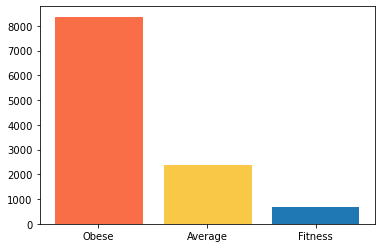

In [502]:
my_bar = plt.bar(['Obese','Average','Fitness'],hist)
my_bar[0].set_color('#F96E46')
my_bar[1].set_color('#F9C846')

[8369, 2367, 670]